# Florence 2 Object Detection Finetuning

In [1]:
# - Packages
import numpy as np
import torch
import cv2
import os

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from torch.utils.data import Dataset, DataLoader

import torch
import supervision as sv

from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)

from peft import LoraConfig, get_peft_model

import albumentations as A

In [2]:
# - Global Variables
data_dir= Path("./snemi/" )
raw_image_dir = data_dir / 'image_pngs'
seg_image_dir = data_dir / 'seg_pngs'
raw_image_slice_dir = data_dir / 'image_slice_pngs'
seg_image_slice_dir = data_dir / 'seg_slice_pngs'
test_iamge_slice_dir = data_dir / "image_slice_test_pngs"
log_dir="./logs"
os.makedirs(log_dir, exist_ok=True)
os.makedirs(raw_image_slice_dir, exist_ok=True)
os.makedirs(seg_image_slice_dir, exist_ok=True)
os.makedirs(test_iamge_slice_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

itrs = 10000

# CHECKPOINT = "microsoft/Florence-2-base-ft"
# REVISION = 'refs/pr/6'

CHECKPOINT = "microsoft/Florence-2-large-ft"
REVISION = 'refs/pr/19'


# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device('cpu')

label_num = 170

## - Define Dataloader
BATCH_SIZE = 2
NUM_WORKERS = 0

## - Lora config
rank = 8
alpha = 8

EPOCHS = 10000
LR = 5e-6

# - Model Initialization

model = AutoModelForCausalLM.from_pretrained(
    CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
processor = AutoProcessor.from_pretrained(
    CHECKPOINT, trust_remote_code=True, revision=REVISION)


## Prepare Dataset and Initialize Dataset and Dataloader

In [3]:
# - Finetuning Dataset Processing
## - Prepare dataset
data = []
for ff, name in enumerate(os.listdir(raw_image_dir)):
    data.append({'image': raw_image_dir / f'image{ff:04d}.png', 'annotation': seg_image_dir / f'seg{ff:04d}.png'})
# - split train dataset and validation dataset
valid_data = data[80:]
data = data[:80]
# - slice image and segmentation for florence sequence length limit
def create_slices(image_path, slice_image_dir):
    img = Image.open(image_path)
     # Get image dimensions
    width, height = img.size
    
    # Calculate the midpoint
    mid_x, mid_y = width // 2, height // 2
    
    # Define the four slices (left, upper, right, lower)
    slices = {
        'top_left': (0, 0, mid_x, mid_y),
        'top_right': (mid_x, 0, width, mid_y),
        'bottom_left': (0, mid_y, mid_x, height),
        'bottom_right': (mid_x, mid_y, width, height)
    }
    
    # Loop through the slices, crop, and save them
    all_slices = []
    for key, coords in slices.items():
        slice_img = img.crop(coords)
        # Format the name: base name + coordinates
        slice_filename = f"{image_path.stem}_{coords[0]}_{coords[1]}_{coords[2]}_{coords[3]}.png"
        slice_img.save( slice_image_dir / slice_filename)
        all_slices.append( slice_image_dir / slice_filename)

    return all_slices

def slice_all_image_seg(data, raw_image_slice_dir, seg_image_slice_dir):
    new_data = []
    for element in data:
        image_path = element['image']
        seg_path = element['annotation']
        image_lst = create_slices(image_path, raw_image_slice_dir)
        seg_lst = create_slices(seg_path, seg_image_slice_dir)

        for i in range(len(image_lst)):
            new_data.append({'image': image_lst[i], 'annotation': seg_lst[i]})
        
    return new_data

data = slice_all_image_seg(data, raw_image_slice_dir, seg_image_slice_dir)
valid_data = slice_all_image_seg(valid_data, raw_image_slice_dir, seg_image_slice_dir)

In [4]:
## - Data augmentation - some invalid box strictly require xmin < xlarge and ymin < y large

## - Convert Mask to Bounding Boxes
def convert_mask2box(mask:np.ndarray):
    inds = np.unique(mask)[1:] # load all indices

    masks = [] 
    for ind in inds:
        masks.append(mask == ind)

    masks = np.array(masks)
    masks_tensor = torch.from_numpy(masks)

    boxes = masks_to_boxes(masks_tensor)
    valid_input_boxes = boxes.numpy()
    return valid_input_boxes

## - normalize location
def normalize_loc(prefix:str, instance_type:str, image_path:str, mask:np.ndarray, input_boxes:np.ndarray):
    x_res = mask.shape[0]
    y_res = mask.shape[1]
    normal_boxes = [[box[0] / x_res * 1000, box[1]/ y_res * 1000, box[2] / x_res * 1000, box[3] / x_res * 1000] for box in input_boxes]
    normal_boxes = np.rint(normal_boxes)
    suffix = ''
    count = 0
    for i in range(len(normal_boxes)):
        #- reach the max sequence length 1024
        if count == label_num:
            break
        x1 = int(normal_boxes[i][0])
        y1 = int(normal_boxes[i][1])
        x2 = int(normal_boxes[i][2])
        y2 = int(normal_boxes[i][3])
        suffix += f"{instance_type}<loc_{x1}><loc_{y1}><loc_{x2}><loc_{y2}>"
        count += 1
        
    
    return {"image": image_path,"prefix": prefix, "suffix": suffix }

# - Apply Albumentations to image and bounding boxes
# Albumentations transformation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, shift_limit=0.1, p=0.5),
    A.RandomBrightnessContrast(p=0.5)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# - Check Invalid Bounding Boxes
def validate_boxes(boxes):
    """Validate and filter out invalid bounding boxes."""
    valid_boxes = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box[:4]
        if x_max > x_min and y_max > y_min:
            valid_boxes.append(box)
    return valid_boxes



def apply_augmentation(image, input_boxes):

    class_labels = [0] * len(input_boxes)  # All neurons are of the same class (update if multi-class)
    augmented = transform(image=image, bboxes=input_boxes, class_labels=class_labels)
    
    return augmented['image'], augmented['bboxes']

def save_augmented_image(image, original_image_path, augmented_image_dir):
    # Convert image array back to image format
    augmented_image = Image.fromarray(image)
    
    # Generate a new file name based on the original
    new_image_filename = f"{original_image_path.stem}_augmented.png"
    new_image_path = augmented_image_dir / new_image_filename
    
    # Save the new image
    augmented_image.save(new_image_path)
    
    return new_image_path

## - Prepare all training dataset and validation dataset
def prepare_dataset(data, instance_type, prefix, augmentation = False):
    dataset = []
    for element in data:
        image_path = element['image']
        seg_path = element['annotation']
        mask = np.array(Image.open(seg_path))
        input_boxes = convert_mask2box(mask)
        # Validate bounding boxes before applying augmentation
        input_boxes = validate_boxes(input_boxes)
        # - Start data augmentation
        if augmentation == True:
            temp_image = np.array(Image.open(image_path))
            augmented_image, augmented_boxes = apply_augmentation(temp_image, input_boxes)
            print(augmented_boxes[0])
            new_image_path = save_augmented_image(augmented_image, image_path, image_path.parent)
            new_curated_data = normalize_loc(prefix, instance_type, new_image_path, mask, augmented_boxes)
            dataset.append(new_curated_data)

        curated_data = normalize_loc(prefix, instance_type, image_path, mask, input_boxes)
        dataset.append(curated_data)
    print(f"Remove Invalid Bounding Boxes xmin >= xlarge or ymin >= ylarge")
    return dataset

train_dataset = prepare_dataset(data, 'neuron', "<OD>", True)
val_dataset = prepare_dataset(valid_data, 'neuron', "<OD>", True)


Remove Invalid Bounding Boxes xmin >= xlarge or ymin >= ylarge
Remove Invalid Bounding Boxes xmin >= xlarge or ymin >= ylarge


In [5]:
# - Initialize Dataset and Dataloader

## - Detection Dataset Class (Dataset Preparation)
class DetectionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        image = cv2.imread(str(data['image']))
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

## - Define Dataloader

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(train_dataset)
val_dataset = DetectionDataset(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=False)

## Image Visualization and Finetuning Process

In [6]:
# - Lora Finetuning Configuration

TARGET_MODULES = [
    "q_proj", "o_proj", "k_proj", "v_proj", 
    "linear", "Conv2d", "lm_head", "fc2"
]

config = LoraConfig(
    r=rank,
    lora_alpha=alpha,
    target_modules=TARGET_MODULES,
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 4,133,576 || all params: 826,827,464 || trainable%: 0.4999



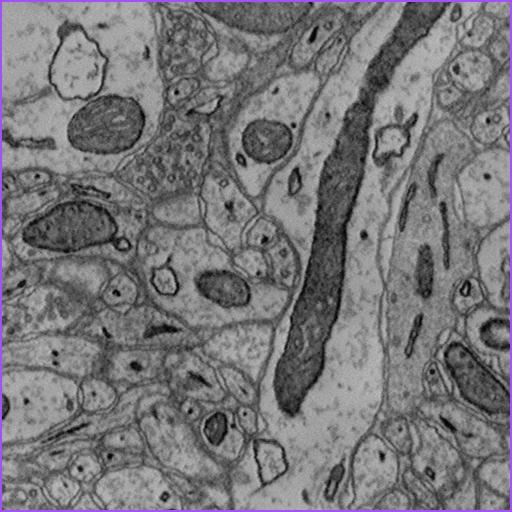
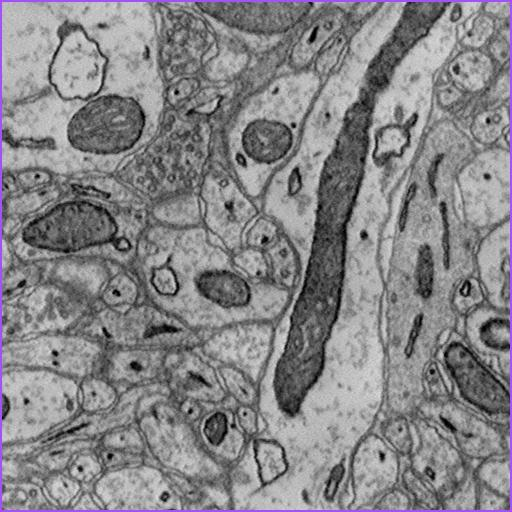
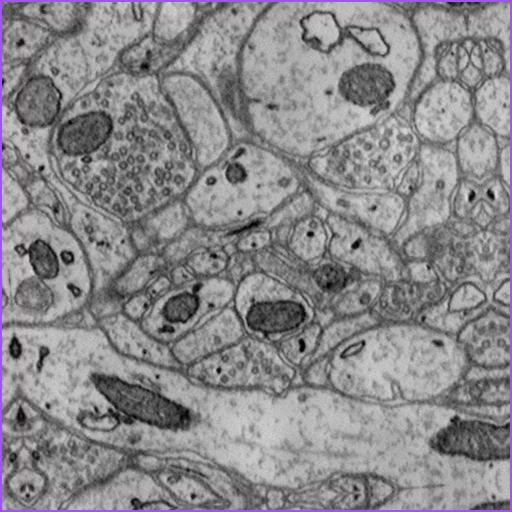
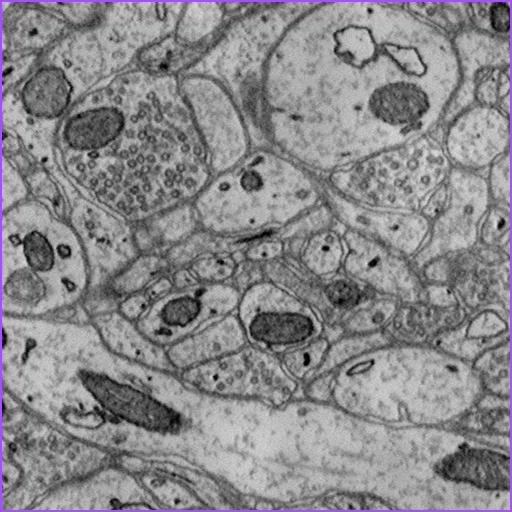

In [7]:
# - Image HTML Visualization
# @title Run inference with pre-trained Florence-2 model on validation dataset
import io
import base64
import html
import json
from IPython.display import HTML
def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
        image = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except:
        print('failed to redner model response')
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(128, 128))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(response))}</p>
</div>
"""


def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        data = dataset.dataset[i]
        image = cv2.imread(str(data['image']))
        image = Image.fromarray(image)
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

render_inference_results(peft_model, val_dataset, 4)


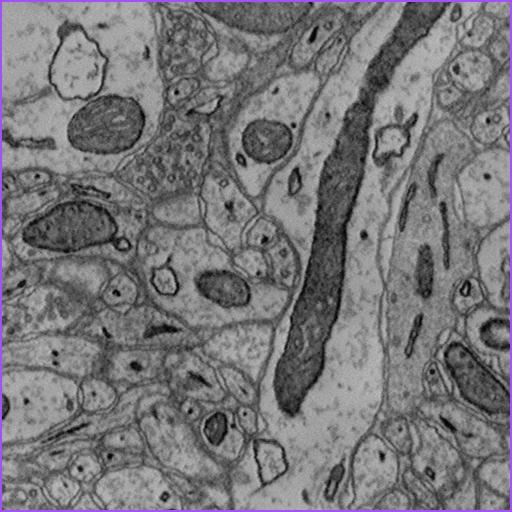
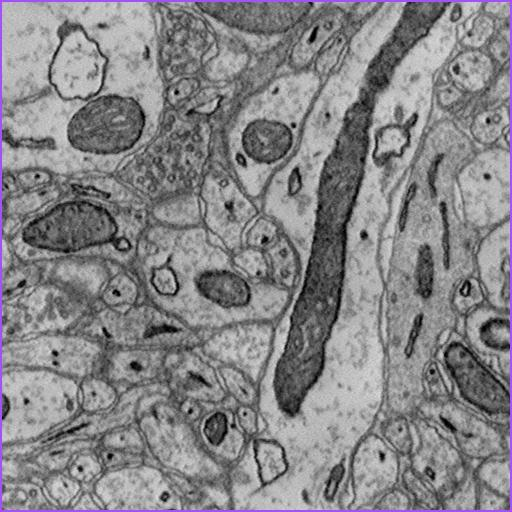
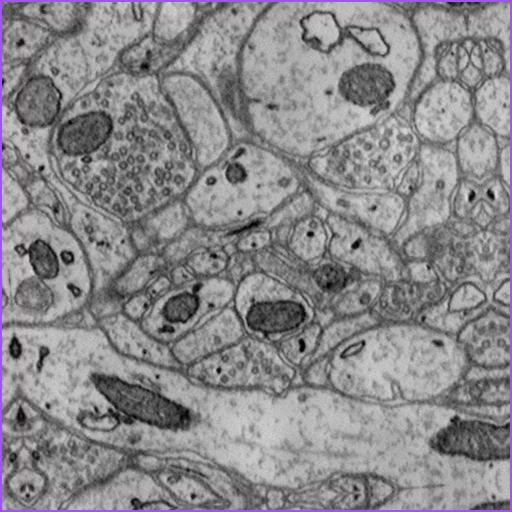
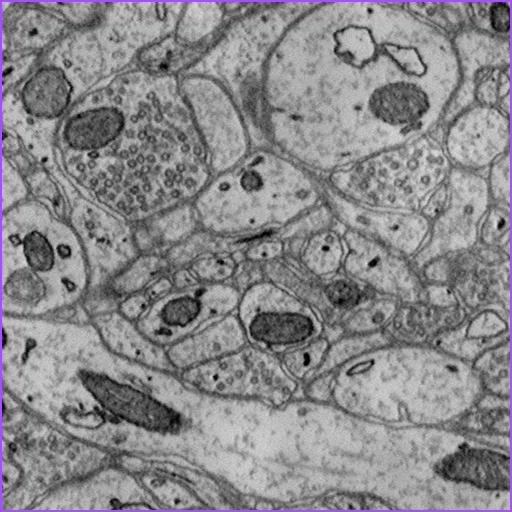
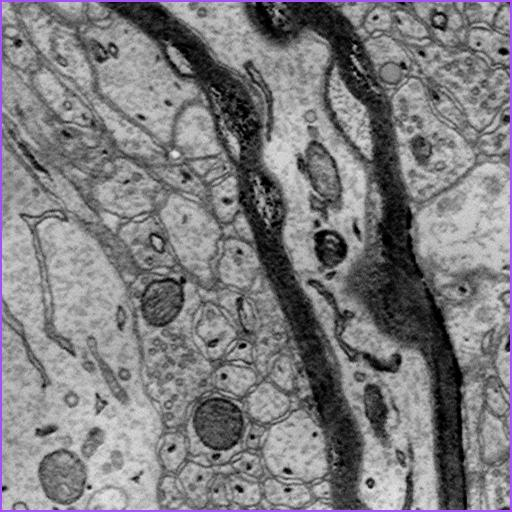
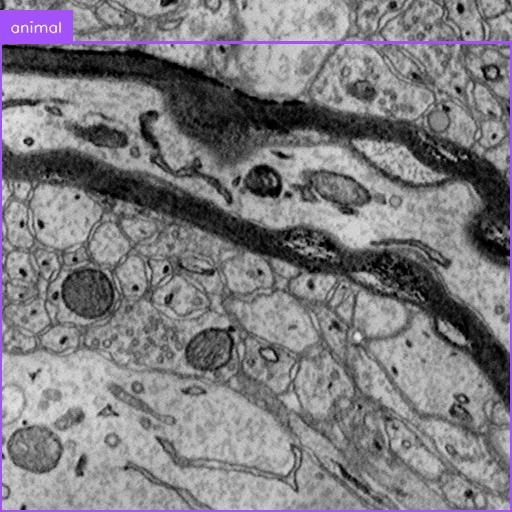

Training Epoch 1/10000:   8%|▊         | 25/320 [00:23<04:36,  1.07it/s]


KeyboardInterrupt: 

In [8]:
# - Training Process
# - define training loop
from tqdm import tqdm
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6, weight_decay=1e-2):
    # AdamW with L2 regularization via weight_decay
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Total number of training steps
    num_training_steps = epochs * len(train_loader)
    
    # Adjust the scheduler to be more gradual (object detection tasks benefit from slower learning rate decay)
    lr_scheduler = get_scheduler(
        name="cosine",
        optimizer=optimizer,
        num_warmup_steps=int(0.1 * num_training_steps),  # 10% warmup steps
        num_training_steps=num_training_steps,
    )

    render_inference_results(peft_model, val_loader.dataset, 6)
    # Open log files for saving training and validation loss
    train_loss_file = open(os.path.join(log_dir, "flo_train_loss.txt"), "w")
    val_loss_file = open(os.path.join(log_dir, "flo_val_loss.txt"), "w")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Save training loss for this epoch
        train_loss_file.write(f"{epoch + 1},{avg_train_loss}\n")
        train_loss_file.flush()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            # Save validation loss for this epoch
            val_loss_file.write(f"{epoch + 1},{avg_val_loss}\n")
            val_loss_file.flush()

            if (epoch + 1) % 100 == 0:
                render_inference_results(peft_model, val_loader.dataset, 6)
                
        if (epoch+1) % 100 == 0:
            output_dir = f"./model_checkpoints/large_model/epoch_{epoch+1}"
            os.makedirs(output_dir, exist_ok=True)
            model.save_pretrained(output_dir)
            processor.save_pretrained(output_dir)
    # Close the log files
    train_loss_file.close()
    val_loss_file.close()
            
train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

In [ ]:
import matplotlib.pyplot as plt

def visualize_loss(log_dir="./logs"):
    # Read training loss from file
    train_loss_file = os.path.join(log_dir, "train_loss.txt")
    val_loss_file = os.path.join(log_dir, "val_loss.txt")

    epochs = []
    train_loss = []
    val_loss = []

    # Read training loss data
    with open(train_loss_file, "r") as f:
        for line in f:
            epoch, loss = line.strip().split(',')
            epochs.append(int(epoch))
            train_loss.append(float(loss))

    # Read validation loss data
    with open(val_loss_file, "r") as f:
        for line in f:
            _, loss = line.strip().split(',')
            val_loss.append(float(loss))

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))

    # Training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Training Loss", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()

    # Validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_loss, label="Validation Loss", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Validation Loss Over Epochs")
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()
